# Figure 5: Annual cycles
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load observations

### Topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [4]:
ds = xr.open_dataset('/data/mlalande/Relief/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation_HR = ds.elevation

## ERA-Interim and ERA5
Downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/ecv-for-climate-change?tab=doc (there are correction but doesn't seem to affect HMA)

For Snow Cover Extent, there is only ERA-Interim on the period 1979-2014 and is computed from snow depth (Appendix A : https://tc.copernicus.org/articles/13/2221/2019/) and https://confluence.ecmwf.int/display/CKB/ERA-Interim%3A+documentation#ERAInterim:documentation-Computationofnear-surfacehumidityandsnowcover

In [5]:
path = '/data/mlalande/ERA-ECV/NETCDF'

In [6]:
tas_era5 = xr.open_dataset(path+'/1month_mean_Global_ea_2t_1979-2014_v02.nc').t2m.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) - 273.15
tas_erai = xr.open_dataset(path+'/1month_mean_Global_ei_t2m_1979-2014_v02.nc').t2m.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) - 273.15
pr_era5 = xr.open_dataset(path+'/1month_mean_Global_ea_tp_1979-2014_v02.nc').tp.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) * 10**3
pr_erai = xr.open_dataset(path+'/1month_mean_Global_ei_tp_1979-2014_v02.nc').tp.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext) * 10**3

In [7]:
regridder = xe.Regridder(tas_era5, elevation, 'bilinear', periodic=False, reuse_weights=True)

obs_ac_regrid_zones = []

for obs in [tas_era5, tas_erai, pr_era5, pr_erai]:
    np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)
    obs_ac = u.annual_cycle(obs, calendar=obs.time.encoding['calendar'])

    # Compute annual cycle for each zones
    temp = [None]*len(zones)
    obs_ac_regrid = regridder(obs_ac)
    for i, zone in enumerate(zones):
        temp[i] = u.spatial_average(
            obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
        )

    obs_ac_regrid_zones.append(xr.concat(temp, pd.Index(zones, name="zone")).load())
    
obs_ac_regrid_zones_tas_era5 = obs_ac_regrid_zones[0]
obs_ac_regrid_zones_tas_erai = obs_ac_regrid_zones[1]
obs_ac_regrid_zones_pr_era5 = obs_ac_regrid_zones[2]
obs_ac_regrid_zones_pr_erai = obs_ac_regrid_zones[3]

Reuse existing file: bilinear_141x241_35x60.nc


### ERA-Interim SCF

In [8]:
SD = xr.open_mfdataset('/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/sd.*.asmei.GLOBAL_075.nc').sd.sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)
RW = 1000
obs = xr.ufuncs.minimum(1, RW*SD/15)*100

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

regridder = xe.Regridder(obs_ac, elevation, 'bilinear', periodic=False, reuse_weights=True)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc_erai = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_47x80_35x60.nc


### ERA5 SCF

In [9]:
# snow water equivalent (ie parameter SD (141.128))
SD = xr.open_mfdataset('/data/mlalande/ERA5/ERA5_monthly_HMA-ext_SD_1979-2014.nc').sd.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)

# RSN is density of snow (parameter 33.128)
RSN = xr.open_dataset('/data/mlalande/ERA5/ERA5_monthly_HMA-ext_RSN_1979-2014.nc').rsn.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)

#  RW is density of water equal to 1000
RW = 1000 

# https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Computationofnear-surfacehumidityandsnowcover
obs = xr.ufuncs.minimum(1, (RW*SD/RSN)/0.1) * 100


# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

regridder = xe.Regridder(obs_ac, elevation, 'bilinear', periodic=False, reuse_weights=True)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc_era5 = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_141x241_35x60.nc


### Temperature

In [10]:
obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar=obs.time.encoding['calendar'])

In [11]:
regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_tas = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_70x120_35x60.nc


### Snow Cover

In [12]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [13]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## ESA snow CCI
We keep it at its original resolution because of NaNs values and use higher resolution topography to define the zones.

In [16]:
path = '/data/mlalande/ESACCI/ESA_CCI_snow_SCFG_v1.0_HKH_gapfilled_monthly'
esa_snc_icefilled = xr.open_dataarray(path+'/ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0_HKH_gapfilled_icefilled_montlhy_1982-2014.nc')
regridder = xe.Regridder(elevation_HR, esa_snc_icefilled, 'bilinear', periodic=False, reuse_weights=True)
elevation_HR_regrid = regridder(elevation_HR)

temp = [None]*len(zones)
esa_snc_ac_icefilled = esa_snc_icefilled.groupby('time.month').mean('time') # otherwise bug with u.annual_cycle (0 on glaciers instead of nan)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        esa_snc_ac_icefilled.sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim[zone]).where(elevation_HR_regrid > 2500)
    )

esa_snc_ac_icefilled_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_560x960_500x1000.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Precipitation

#### APHRODITE

In [17]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [18]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_pr_aphro = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### GPCP

In [19]:
obs_longname = 'GPCP CDR v2.3 (2.5°)'
obs_name = 'GPCP'

obs = xr.open_mfdataset(
    # '/bdd/GPCP/netcdf/surf-rr_gpcp_multi-sat_250d_01mth_*_v2.2-02.nc', combine='by_coords'
    # -> missing some month (ex 2014/11)
    '/data/mlalande/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period, latitude=latlim_ext, longitude=lonlim_ext)

obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

In [20]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_pr_gpcp = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_14x24_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load results

In [21]:
list_vars = ['tas', 'snc', 'pr']
temp = [None]*len(list_vars)

for i, var in enumerate(list_vars):
    temp[i] = xr.open_dataarray(
        'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_ac.nc'
    )
    
multimodel_ensemble_ac = xr.concat(temp, pd.Index(list_vars, name='var'))

In [22]:
multimodel_ensemble_ac = multimodel_ensemble_ac.sel(model=['BCC-CSM2-MR', 'BCC-ESM1', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2',
       'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'GFDL-CM4', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
       'NorESM2-LM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL'])

In [23]:
# multimodel_ensemble_ac

## Plot

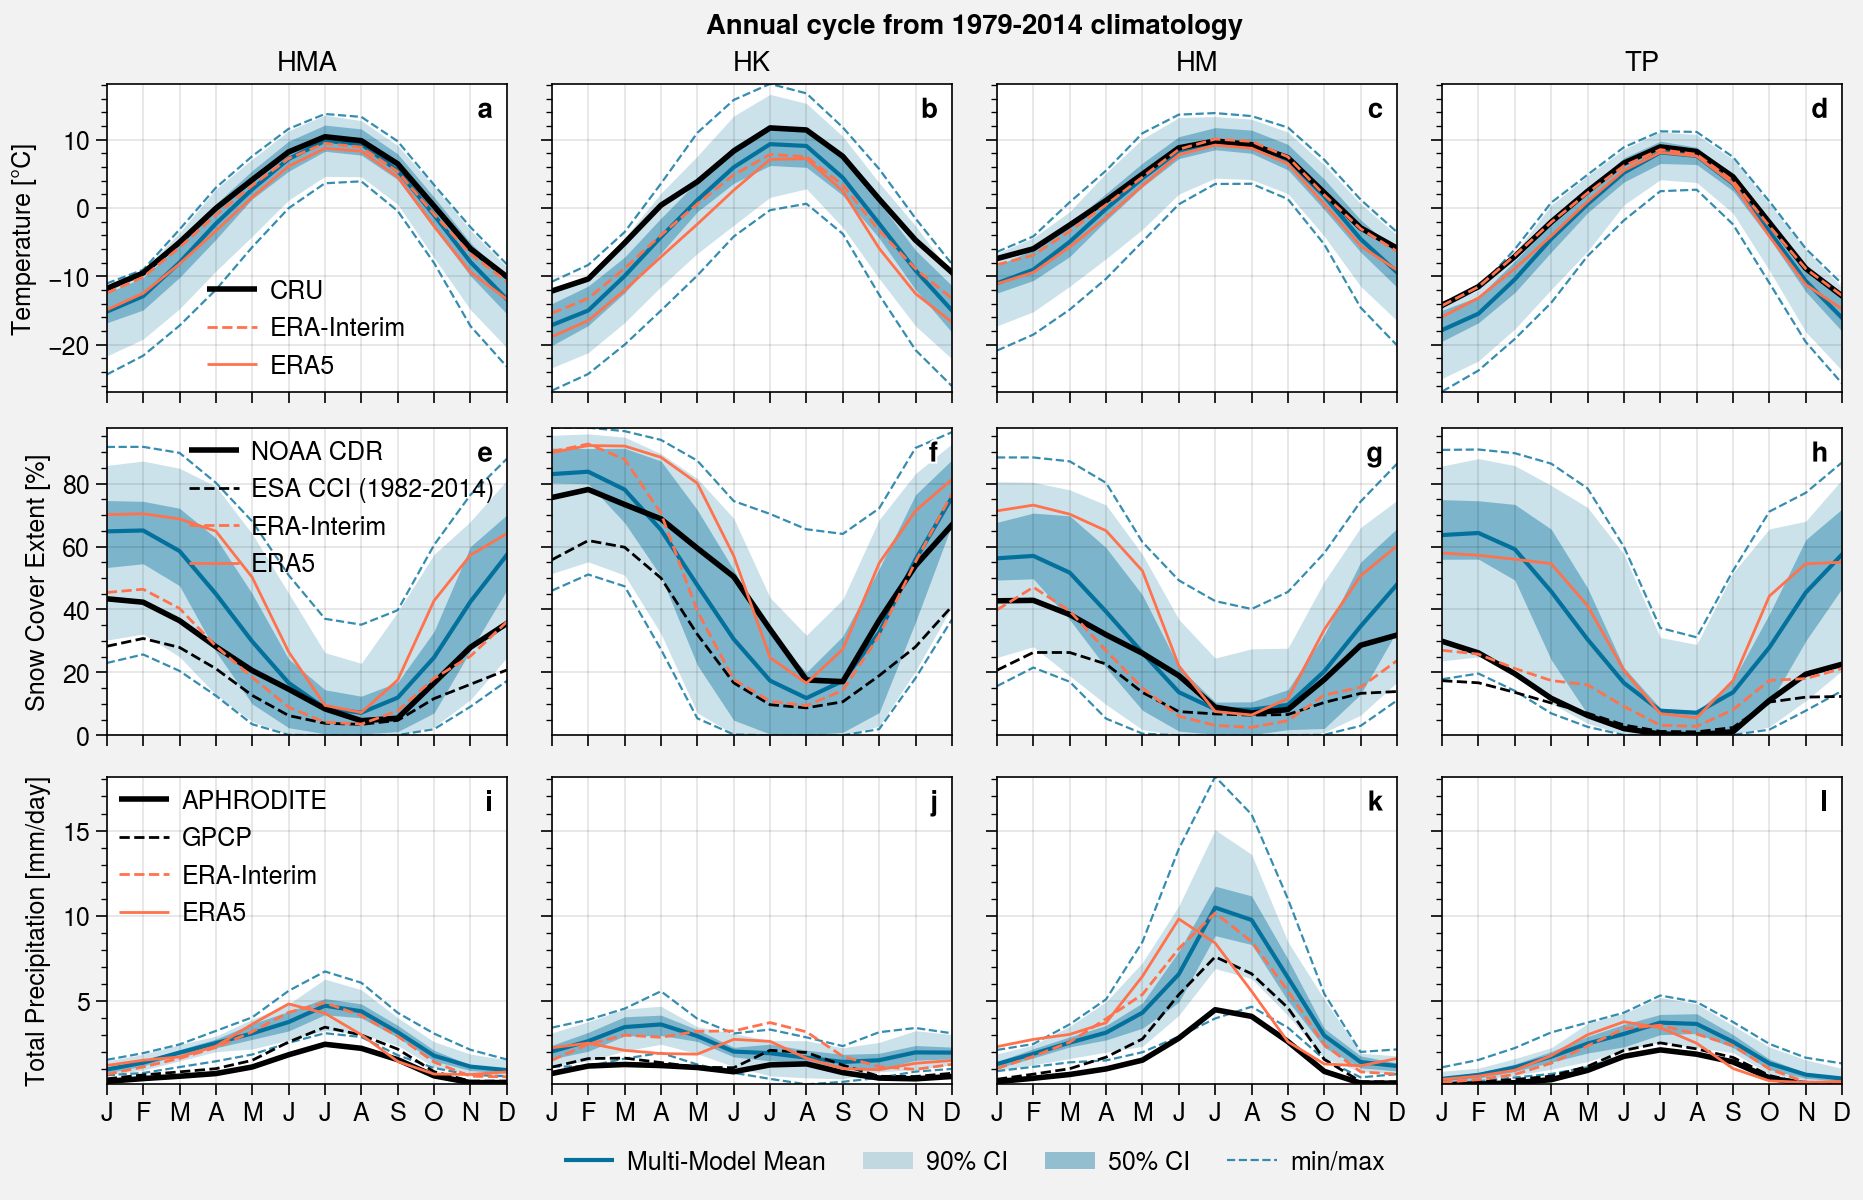

In [26]:
f, axs = plot.subplots(ncols=4, nrows=3, aspect=1.3, sharey=0, axwidth=2)

color_model = 'ocean blue'
color_obs = 'black'
color_era = 'pink orange'

n_ax = 0
for i_var, var in enumerate(list_vars):
    for i in range(len(zones)):
        means = multimodel_ensemble_ac.sel(var=var)[i].mean('model')

        # Compute quantiles  
        shadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.25, 0.75], dim='model')  # dark shading
        fadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.05, 0.95], dim='model')  # light shading

        h1 = axs[n_ax].plot(
            means, 
            shadedata=shadedata, fadedata=fadedata,
            shadelabel='50% CI', fadelabel='90% CI',
            label='Multi-Model Mean', color=color_model, 
        )

        # Add min/max
        h2 = axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].min('model'),
            label='min/max', linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )
        axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].max('model'),
            linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )

        # Plot observations
        if var == 'tas':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_tas[i], label='CRU', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(obs_ac_regrid_zones_tas_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
            h5 = axs[n_ax].plot(obs_ac_regrid_zones_tas_era5[i], label='ERA5', color=color_era, linewidth=1)
        elif var == 'snc':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_snc[i], label='NOAA CDR', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(esa_snc_ac_icefilled_zones[i], label='ESA CCI (1982-2014)', color=color_obs, linewidth=1, linestyle='--')
            h5 = axs[n_ax].plot(obs_ac_regrid_zones_snc_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
            h6 = axs[n_ax].plot(obs_ac_regrid_zones_snc_era5[i], label='ERA5', color=color_era, linewidth=1)
        elif var == 'pr':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_pr_aphro[i], label='APHRODITE', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(obs_ac_regrid_zones_pr_gpcp[i], label='GPCP', color=color_obs, linewidth=1, linestyle='--')
            h5 = axs[n_ax].plot(obs_ac_regrid_zones_pr_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
            h6 = axs[n_ax].plot(obs_ac_regrid_zones_pr_era5[i], label='ERA5', color=color_era, linewidth=1)
        
        if i == 0:
            axs[n_ax].format( 
                ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
                xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
                xlabel=''
            )
        else:
            axs[n_ax].format( 
                ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
                xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
                xlabel='',
                yticklabels=[]
            )
            
        
        if i_var == 0:
            axs[n_ax].format(title=zones[n_ax])
        
        # Add obs legend and ylabel
        if i == 0:
            if var == 'tas':
                h = [h3, h4, h5]
                loc = 'lc'
            elif var == 'snc':
                h = [h3, h4, h5, h6]
                loc = 'ur'
            elif var == 'pr':
                h = [h3, h4, h5, h6]
                loc = 'ul'
            axs[n_ax].legend(h, loc=loc, frame=False, ncols=1)
            
            labels=['Temperature [°C]', 'Snow Cover Extent [%]', 'Total Precipitation [mm/day]']
            axs[n_ax].format( 
                ylabel = labels[i_var]
            )
        
        n_ax += 1

f.legend([h1[0], h1[1], h1[2], h2], loc='b', frame=False, ncols=4, order='F', center=False)

axs.format(
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology',
#     collabels=zones,
    abc=True, abcloc='ur'
)
    
filename = 'fig5_ac_all_'+period.start+'-'+period.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')